In [26]:
from commons.load_data import load_data
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch 

In [27]:
INPUT_DIMS = (28, 28)

class AutoEnc(torch.nn.Module):
    def __init__(self, latent_dims = 64) -> None:
        super(AutoEnc, self).__init__()
        # encoder
        self.flatten = torch.nn.Flatten()
        self.linear1 = torch.nn.Linear(INPUT_DIMS[0] * INPUT_DIMS[1], 512)
        self.linear2 = torch.nn.Linear(512, 128)
        self.linear3 = torch.nn.Linear(128, latent_dims)

        # decoder 
        self.linear4 = torch.nn.Linear(latent_dims, 128)
        self.linear5 = torch.nn.Linear(128, 512)
        self.linear6 = torch.nn.Linear(512, INPUT_DIMS[0] * INPUT_DIMS[1])

    def encoder(self, input: torch.Tensor) -> torch.Tensor:
        x = self.flatten(input)

        x = self.linear1(x)
        x = F.selu(x)

        x = self.linear2(x)
        x = F.selu(x)

        latent_space = self.linear3(x)
        return latent_space

    def decoder(self, latent_space: torch.Tensor) -> torch.Tensor:
        x = F.selu(latent_space)
        
        x = self.linear4(x)
        x = F.selu(x)

        x = self.linear5(x)
        x = F.selu(x)

        x = self.linear6(x)
        x = torch.sigmoid(x)

        x = torch.reshape(x, (-1, 1, *INPUT_DIMS))
        return x


    def forward(self, input: torch.Tensor) -> torch.Tensor:
        # encoder
        latent_space = self.encoder(input)
        # decoder 
        output = self.decoder(latent_space)
        return output
        

In [28]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

train_data, test_data = load_data() # load in data

epochs = 60
batch_size = 32

train = torch.utils.data.DataLoader(train_data, batch_size = batch_size)
test = torch.utils.data.DataLoader(test_data, batch_size = batch_size)

loss_fn = torch.nn.BCELoss()

model = AutoEnc(latent_dims = 16)
opt = torch.optim.SGD(model.parameters(), lr = .00008, weight_decay = 5e-4, momentum = 0) # penalizing square of encoded activation could make the network select only one awsners 
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, 'min', factor = .2, patience = 1, verbose = True, cooldown = 3)

model.to(device)

AutoEnc(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=784, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=128, bias=True)
  (linear3): Linear(in_features=128, out_features=16, bias=True)
  (linear4): Linear(in_features=16, out_features=128, bias=True)
  (linear5): Linear(in_features=128, out_features=512, bias=True)
  (linear6): Linear(in_features=512, out_features=784, bias=True)
)

In [29]:
print(f'Training Started 0/{epochs} epochs')
for epoch in range(epochs):
    train_loss = 0 # init train loss to 0

    for imgs, _ in tqdm(train, mininterval= 0.5):
        imgs = imgs.to(device)
        outputs = model(imgs)
        loss = loss_fn(outputs, imgs)

        loss.backward()
        opt.step()
        train_loss += loss.item() 

    test_loss = 0 
    with torch.no_grad():
        for imgs, _ in test:
            imgs = imgs.to(device)
            outputs = model(imgs)
            loss = loss_fn(outputs, imgs)
            test_loss += loss.item() 
            
    train_loss /= len(train)
    test_loss /= len(test)

    print(f"Epoch: {epoch + 1}/{epochs} complete\tTrain loss: {train_loss:.5f}\t Test loss: {test_loss:.5f}")

    scheduler.step(test_loss)


Training Started 0/60 epochs


100%|██████████| 1875/1875 [00:09<00:00, 188.75it/s]


Epoch: 1/60 complete	Train loss: 0.44068	 Test loss: 0.29432


100%|██████████| 1875/1875 [00:10<00:00, 171.73it/s]


Epoch: 2/60 complete	Train loss: 0.28238	 Test loss: 0.28624


100%|██████████| 1875/1875 [00:11<00:00, 165.61it/s]


Epoch: 3/60 complete	Train loss: 0.28015	 Test loss: 0.27130


100%|██████████| 1875/1875 [00:11<00:00, 164.62it/s]


Epoch: 4/60 complete	Train loss: 0.26454	 Test loss: 0.26238


100%|██████████| 1875/1875 [00:11<00:00, 163.11it/s]


Epoch: 5/60 complete	Train loss: 0.26087	 Test loss: 0.25760


100%|██████████| 1875/1875 [00:12<00:00, 149.07it/s]


Epoch: 6/60 complete	Train loss: 0.26187	 Test loss: 0.26255


100%|██████████| 1875/1875 [00:12<00:00, 152.00it/s]


Epoch: 7/60 complete	Train loss: 0.26328	 Test loss: 0.26089
Epoch     7: reducing learning rate of group 0 to 1.6000e-05.


100%|██████████| 1875/1875 [00:12<00:00, 155.19it/s]


Epoch: 8/60 complete	Train loss: 0.25020	 Test loss: 0.24620


100%|██████████| 1875/1875 [00:12<00:00, 150.75it/s]


Epoch: 9/60 complete	Train loss: 0.24877	 Test loss: 0.24623


100%|██████████| 1875/1875 [00:12<00:00, 155.50it/s]


Epoch: 10/60 complete	Train loss: 0.24871	 Test loss: 0.24838


100%|██████████| 1875/1875 [00:11<00:00, 158.12it/s]


Epoch: 11/60 complete	Train loss: 0.24755	 Test loss: 0.24460


100%|██████████| 1875/1875 [00:11<00:00, 158.21it/s]


Epoch: 12/60 complete	Train loss: 0.24737	 Test loss: 0.24344


100%|██████████| 1875/1875 [00:11<00:00, 157.68it/s]


Epoch: 13/60 complete	Train loss: 0.24753	 Test loss: 0.24841


100%|██████████| 1875/1875 [00:11<00:00, 159.39it/s]


Epoch: 14/60 complete	Train loss: 0.24697	 Test loss: 0.24524
Epoch    14: reducing learning rate of group 0 to 3.2000e-06.


100%|██████████| 1875/1875 [00:12<00:00, 154.23it/s]


Epoch: 15/60 complete	Train loss: 0.24018	 Test loss: 0.23707


100%|██████████| 1875/1875 [00:11<00:00, 156.95it/s]


Epoch: 16/60 complete	Train loss: 0.23975	 Test loss: 0.23856


100%|██████████| 1875/1875 [00:11<00:00, 158.47it/s]


Epoch: 17/60 complete	Train loss: 0.23774	 Test loss: 0.23834


100%|██████████| 1875/1875 [00:11<00:00, 160.46it/s]


Epoch: 18/60 complete	Train loss: 0.23658	 Test loss: 0.23366


100%|██████████| 1875/1875 [00:12<00:00, 155.79it/s]


Epoch: 19/60 complete	Train loss: 0.23629	 Test loss: 0.23667


100%|██████████| 1875/1875 [00:11<00:00, 159.85it/s]


Epoch: 20/60 complete	Train loss: 0.23631	 Test loss: 0.23370
Epoch    20: reducing learning rate of group 0 to 6.4000e-07.


100%|██████████| 1875/1875 [00:12<00:00, 153.49it/s]


Epoch: 21/60 complete	Train loss: 0.23298	 Test loss: 0.22951


100%|██████████| 1875/1875 [00:11<00:00, 158.33it/s]


Epoch: 22/60 complete	Train loss: 0.22878	 Test loss: 0.22761


100%|██████████| 1875/1875 [00:12<00:00, 153.70it/s]


Epoch: 23/60 complete	Train loss: 0.22836	 Test loss: 0.22930


100%|██████████| 1875/1875 [00:11<00:00, 157.26it/s]


Epoch: 24/60 complete	Train loss: 0.22980	 Test loss: 0.22816


100%|██████████| 1875/1875 [00:11<00:00, 158.61it/s]


Epoch: 25/60 complete	Train loss: 0.22899	 Test loss: 0.22755


100%|██████████| 1875/1875 [00:11<00:00, 157.78it/s]


Epoch: 26/60 complete	Train loss: 0.22729	 Test loss: 0.22634


100%|██████████| 1875/1875 [00:11<00:00, 157.54it/s]


Epoch: 27/60 complete	Train loss: 0.22748	 Test loss: 0.22626


100%|██████████| 1875/1875 [00:11<00:00, 161.04it/s]


Epoch: 28/60 complete	Train loss: 0.22674	 Test loss: 0.22567


100%|██████████| 1875/1875 [00:11<00:00, 158.08it/s]


Epoch: 29/60 complete	Train loss: 0.22600	 Test loss: 0.22478


100%|██████████| 1875/1875 [00:12<00:00, 155.90it/s]


Epoch: 30/60 complete	Train loss: 0.22609	 Test loss: 0.22564


100%|██████████| 1875/1875 [00:13<00:00, 138.48it/s]


Epoch: 31/60 complete	Train loss: 0.22598	 Test loss: 0.22453


100%|██████████| 1875/1875 [00:12<00:00, 144.55it/s]


Epoch: 32/60 complete	Train loss: 0.22539	 Test loss: 0.22440


100%|██████████| 1875/1875 [00:12<00:00, 145.08it/s]


Epoch: 33/60 complete	Train loss: 0.22505	 Test loss: 0.22398


100%|██████████| 1875/1875 [00:12<00:00, 148.05it/s]


Epoch: 34/60 complete	Train loss: 0.22436	 Test loss: 0.22305


100%|██████████| 1875/1875 [00:12<00:00, 146.51it/s]


Epoch: 35/60 complete	Train loss: 0.22426	 Test loss: 0.22320


100%|██████████| 1875/1875 [00:12<00:00, 145.36it/s]


Epoch: 36/60 complete	Train loss: 0.22296	 Test loss: 0.22169


100%|██████████| 1875/1875 [00:12<00:00, 145.33it/s]


Epoch: 37/60 complete	Train loss: 0.22272	 Test loss: 0.22124


100%|██████████| 1875/1875 [00:11<00:00, 157.78it/s]


Epoch: 38/60 complete	Train loss: 0.22248	 Test loss: 0.22208


100%|██████████| 1875/1875 [00:12<00:00, 156.21it/s]


Epoch: 39/60 complete	Train loss: 0.22254	 Test loss: 0.22022


100%|██████████| 1875/1875 [00:11<00:00, 160.12it/s]


Epoch: 40/60 complete	Train loss: 0.22181	 Test loss: 0.22020


100%|██████████| 1875/1875 [00:12<00:00, 154.17it/s]


Epoch: 41/60 complete	Train loss: 0.22137	 Test loss: 0.22018


100%|██████████| 1875/1875 [00:12<00:00, 146.18it/s]


Epoch: 42/60 complete	Train loss: 0.22160	 Test loss: 0.22052


100%|██████████| 1875/1875 [00:11<00:00, 156.40it/s]


Epoch: 43/60 complete	Train loss: 0.22075	 Test loss: 0.21949


100%|██████████| 1875/1875 [00:12<00:00, 155.87it/s]


Epoch: 44/60 complete	Train loss: 0.21921	 Test loss: 0.21687


100%|██████████| 1875/1875 [00:12<00:00, 156.01it/s]


Epoch: 45/60 complete	Train loss: 0.21911	 Test loss: 0.21781


100%|██████████| 1875/1875 [00:12<00:00, 153.68it/s]


Epoch: 46/60 complete	Train loss: 0.21890	 Test loss: 0.21730
Epoch    46: reducing learning rate of group 0 to 1.2800e-07.


100%|██████████| 1875/1875 [00:11<00:00, 157.74it/s]


Epoch: 47/60 complete	Train loss: 0.21789	 Test loss: 0.21635


100%|██████████| 1875/1875 [00:12<00:00, 155.05it/s]


Epoch: 48/60 complete	Train loss: 0.21636	 Test loss: 0.21433


100%|██████████| 1875/1875 [00:12<00:00, 154.93it/s]


Epoch: 49/60 complete	Train loss: 0.21435	 Test loss: 0.21195


100%|██████████| 1875/1875 [00:12<00:00, 155.20it/s]


Epoch: 50/60 complete	Train loss: 0.21333	 Test loss: 0.21139


100%|██████████| 1875/1875 [00:12<00:00, 154.83it/s]


Epoch: 51/60 complete	Train loss: 0.21274	 Test loss: 0.21230


100%|██████████| 1875/1875 [00:11<00:00, 157.20it/s]


Epoch: 52/60 complete	Train loss: 0.21326	 Test loss: 0.21300
Epoch    52: reducing learning rate of group 0 to 2.5600e-08.


100%|██████████| 1875/1875 [00:12<00:00, 155.97it/s]


Epoch: 53/60 complete	Train loss: 0.21342	 Test loss: 0.21224


100%|██████████| 1875/1875 [00:13<00:00, 143.85it/s]


Epoch: 54/60 complete	Train loss: 0.21322	 Test loss: 0.21277


100%|██████████| 1875/1875 [00:11<00:00, 157.85it/s]


Epoch: 55/60 complete	Train loss: 0.21348	 Test loss: 0.21223


100%|██████████| 1875/1875 [00:11<00:00, 158.43it/s]


Epoch: 56/60 complete	Train loss: 0.21262	 Test loss: 0.21181


100%|██████████| 1875/1875 [00:12<00:00, 154.36it/s]


Epoch: 57/60 complete	Train loss: 0.21287	 Test loss: 0.21206
Epoch    57: reducing learning rate of group 0 to 5.1200e-09.


100%|██████████| 1875/1875 [00:11<00:00, 157.80it/s]


Epoch: 58/60 complete	Train loss: 0.21268	 Test loss: 0.21161


100%|██████████| 1875/1875 [00:11<00:00, 160.47it/s]


Epoch: 59/60 complete	Train loss: 0.21210	 Test loss: 0.21096


100%|██████████| 1875/1875 [00:12<00:00, 155.24it/s]


Epoch: 60/60 complete	Train loss: 0.21162	 Test loss: 0.21069


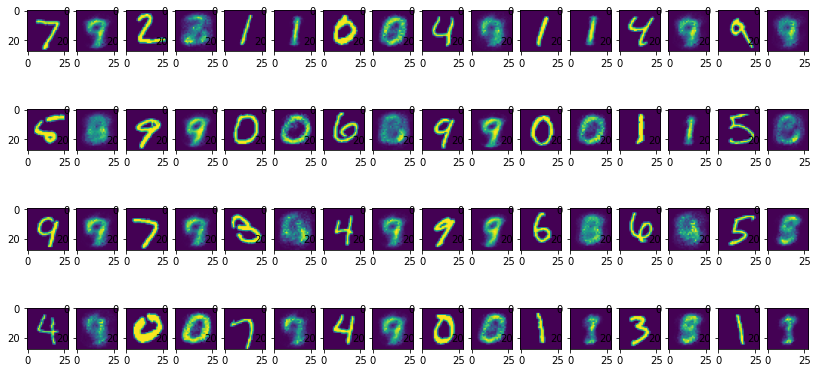

In [33]:
images, _ = iter(test).next()
_, ax = plt.subplots(4, 16, figsize = (14, 7))
with torch.no_grad():
    outputs = model(images)

ax_flat = ax.flatten()
for i in range(0, len(ax_flat), 2):
    ax_flat[i+1].imshow(outputs[i//2][0].numpy())
    ax_flat[i].imshow(images[i//2][0].numpy())

In [31]:

outputs.shape

torch.Size([32, 1, 28, 28])